In [1]:
import datetime
import math
from itertools import product
from random import choices, randint
from typing import List, Tuple

import numpy as np
import shapely.affinity as affinity
import shapely.geometry as geo
import vsketch
from sklearn.neighbors import NearestNeighbors


In [2]:
# helper funcs, ignore
DISPLAY_RATIO = 1.5

def display(sketch):
    return sketch.display("matplotlib", fig_size=(6*DISPLAY_RATIO,4*DISPLAY_RATIO))

## Canvas

The canvas is usually the first thing you'll declare. You can declare the size of the canvas in any unit (inches, cm, pixels). We'll use `6in x 4in`.

We can also automatically center anything drawn to the canvas, though the 'centering' process happens at display time. 

You can draw things that extend beyond your canvas, which we will take advantage of in creating our line fill. The canvas is really there to help you orient where you want to place things.

`(0, 0)` is the **upper** left corner, not the lower left corner. We'll draw a line from the top left to lower right corner there just for an example.

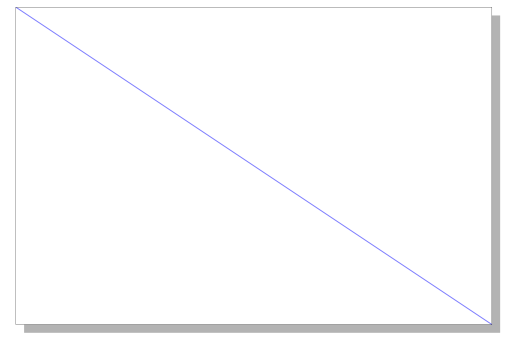

In [3]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

vsk.line(0, 0, W, H)

display(vsk)

## Borders

To make sure our drawing does not go past the edge of the canvas, I always like to include a border. In the end result, we will use the border and the _intersection_ of any objects drawn to canvas to plot. Meaning, only objects _inside_ the border will be drawn. 

Below we'll create and display the border object. Usually I do not display borders in most of my pieces, but you can. This also illustrates the idea of that you can objects that aren't directly displayed, but help in other ways to create a final piece.

## Shapely

`vsketch` provides some primitives like lines and circles, but `shapely` is a much more powerful way of making and creating objects because you can apply set-theoretic operations to them, which allows you to combine them in interesting ways. This is how we create the _border_ object. `vsketch` has an API for drawing _ANY_ shapely geometry, which is what we'll use.

![](https://shapely.readthedocs.io/en/stable/_images/intersection-sym-difference.png)

If you work with `shapefiles` in python for GIS work, you will likely use shapely.

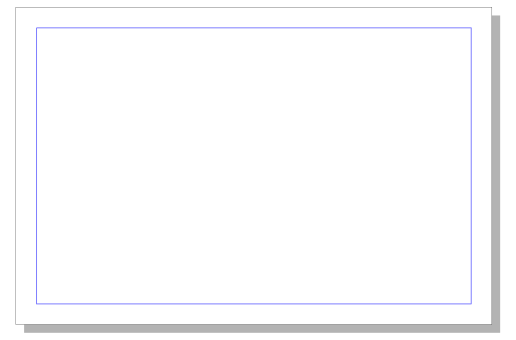

In [4]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

MARGIN = 25
# linear ring is a connected set of lines that form a "ring" 
# i.e. the first point connects to the last
BORDER = geo.LinearRing(
    [
        (MARGIN, MARGIN),
        (MARGIN, H - MARGIN),
        (W - MARGIN, H - MARGIN),
        (W - MARGIN, MARGIN),
    ]
)
# There are cases where we want to use a Polygon instead of the LinearRing object
BORDER_POLYGON = geo.Polygon(BORDER)

# Add the shapely geometry object to our canvas
vsk.geometry(BORDER_POLYGON)
display(vsk)


## Shapes

Shapes are fun! There are many different ways to construct a shape using different shape definitions. We want to create 3 helper functions for our shapes that take the same arguments, so that we can randomly select from them for our shape drawing and pass them the same type of values across functions. Our functions will take a center point for drawing, and a "radius" -- the furthest point from the center to a point on the shape.

With `shapely`, a circle is created by creating a single point, then drawing a _buffer_ (radius) around it. Since a circle is an "infinite sided polygon", we actually approximate a circle by declaring a `resolution` and then connecting a series of points on a circle. 

One weird thing here is that we create a _diamond_ by drawing a circle, but lowering the resolution to `1`. This is a representation of a circle with only 4 points representing it (thus a diamond). 

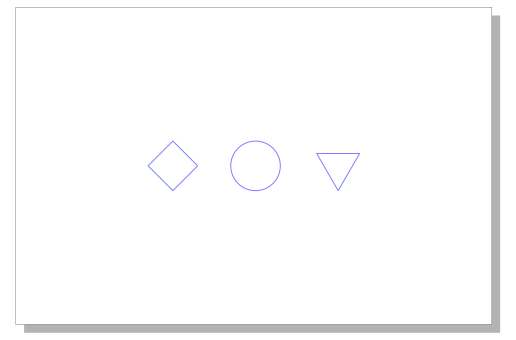

In [5]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

# usual point instantiation
# point = geo.Point(x, y)

def circle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 16)

def diamond(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 1)

# https://stackoverflow.com/q/65544295
def triangle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    side_length = radius * math.sqrt(3)
    # Calculate three vertices of the container triangle
    a = [center[0], center[1] + (math.sqrt(3) / 3) * side_length]  # Top vertex
    b = [
        center[0] - (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]  # Bottom left vertex
    c = [
        center[0] + (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]
    return geo.Polygon([a, b, c])


shapefuncs = [diamond, circle, triangle]

centers = [(100, 100), (200, 100), (300, 100)]

for shape, center in zip(shapefuncs, centers):
    vsk.geometry(shape(center, 30))

display(vsk)

## A Grid
There are many ways to create a grid. We'll parameterize ours by the desired radius of shapes we want. The way to think of this is: starting at the left and top margin, how many shapes can can we draw with a desired radius until we reach the margin on the other side? 

Note that unless our border size is evenly divisible by our spacing, this will result in an 'uncentered' grid, so the final `center`ing really helps us out. I've turned off `center` for this sketch to illustrate this issue.

## Layers
We'll also see our first use of layers here. I will put the border in a separate "layer" so we can visualize it distinctly. We will use layers in an actual plot to indicate things that should be drawn with a different pen.

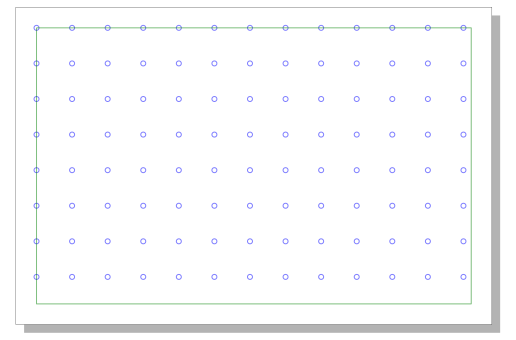

In [6]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=False)

MARGIN = 25

RADIUS = 21

# A RADIUS is 1/2 of the diameter (full width) of a shape
# RADIUS * 2 would place shapes right next to each other
# We also add a little buffer of 0.05 to space our points
SPACING = RADIUS * (2 + 0.05)

xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
points = []
for x, y in product(xrange, yrange):
    points.append((x, y))

vsk.stroke(1)
for p in points:
    vsk.geometry(geo.Point(*p).buffer(3))

vsk.stroke(2)
vsk.geometry(BORDER_POLYGON)

display(vsk)


## Background Fill with Lines

This we will create manually. There are tools to automatically "fill" polygons depending on the pen width, but since we want a specific pattern, we will have to write our own fill pattern.

What we'll do to fill the shapes in the final piece is create our lined fill pattern, then for each shape, find the intersection (with `shapely`) of that shape with a line fill. That will essentially "fill" the shape with that pattern.

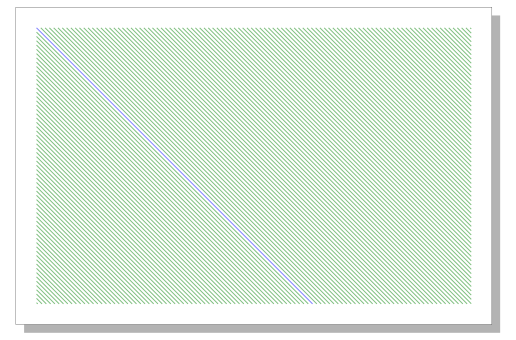

In [7]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

max_dim = max(vsk.width, vsk.height)

# The "step" should be the pen width * 2
# That way, we have a "gap" of exactly the pen width
vsk.penWidth("0.5mm")
step = vsk.strokePenWidth * 2

vertical_lines = []
diag_right_lines = []
diag_left_lines = []

# Draw vertical lines, top to bottom, from the left to the right of the canvas
for x in np.arange(0, max_dim, step=step):
    vertical_lines.append(geo.LineString([(x, 0), (x, max_dim)]))

# Draw a "template" line from the upper-left diagonal down right
diag_right_base = geo.LineString([(0, 0), (max_dim, max_dim)])
diag_right_lines = [diag_right_base]

# Draw a template line from the lower-left diagonal up right
diag_left_base = geo.LineString([(0, max_dim), (max_dim, 0)])
diag_left_lines = [diag_left_base]

# For each diagonal template line, make copies above and below that diagonal
# Note that this arange is way too far, so we'll cheat and just find the intersection
# With the border
for r in np.arange(step, max_dim, step=step):
    diag_right_lines.append(affinity.translate(diag_right_base, r*math.sqrt(step/2), 0))
    diag_right_lines.append(affinity.translate(diag_right_base, 0, r*math.sqrt(step/2)))
    diag_left_lines.append(affinity.translate(diag_left_base, -r*math.sqrt(step/2), 0))
    diag_left_lines.append(affinity.translate(diag_left_base, 0, r*math.sqrt(step/2)))

layer_lines = [vertical_lines, diag_right_lines, diag_left_lines]

# If you want to see all lines, set this to true
# otherwise, we'll illustrate the template + translations with a diagonal
DRAW_ALL_LINES = False

if DRAW_ALL_LINES:
    for i, layer in enumerate(layer_lines, 1):
        vsk.stroke(i)
        vsk.geometry(BORDER_POLYGON.intersection(geo.MultiLineString(layer)))
else:
    for i, line in enumerate(diag_right_lines):
        if i == 0:
            vsk.stroke(1)
            vsk.geometry(BORDER_POLYGON.intersection(line))
        else:
            vsk.stroke(2)
            vsk.geometry(BORDER_POLYGON.intersection(line))

display(vsk)


## Voronoi


Going back to our grid, we need a way to declare "neighborhoods" where shapes are roughly the same. In geometry land, this is done using a Voronoi diagram. 


> a Voronoi diagram is a partition of a plane into regions close to each of a given set of objects.



<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/54/Euclidean_Voronoi_diagram.svg/1200px-Euclidean_Voronoi_diagram.svg.png" width="400">

Since we're data scientists, we might also know this by another name...


<img src="https://i.imgflip.com/5kcmna.jpg" width="400">


Each "point" here can be thought of as a label for k-nearest-neighbors. If for some new point we want to know how it should be labeled, we ask "what is the label of the closest point to this new point?" - aka, k=1 in KNN.

We'll build this on our grid and illustrate below.

For our application, to add some randomness we will randomly select N points from the grid to be our "centroids". Then, for each other point in the grid, we will ask which centroid is closest (aka, what's the "label" of the nearest centroid)

We'll repeat this process for each layer, so each layer should have a different set of neighborhoods when the points change.

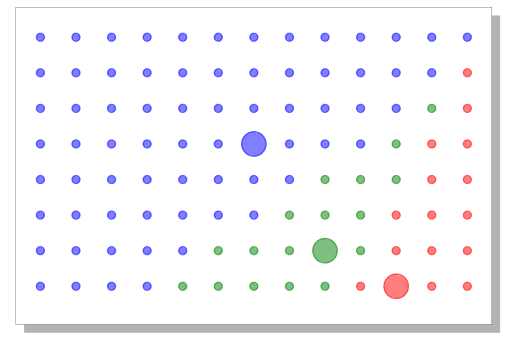

In [8]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

MARGIN = 25

RADIUS = 21
SPACING = RADIUS * (2 + 0.05)

xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
points = []
for x, y in product(xrange, yrange):
    points.append((x, y))

def knn_grid(
    grid_points: List[Tuple[float, float]], n_centers: int = 3, metric: str = "euclidean"
):
    centers = choices(grid_points, k=n_centers)  # choose k points to be "centers"
    neigh = NearestNeighbors(n_neighbors=1, metric=metric)
    neigh.fit(centers)  # fit knn on those centers as the 'label'
    # for each point, return the 1st nearest neighbor
    closest_point = neigh.kneighbors(points, 1, return_distance=False)
    labels = list(c[0] for c in closest_point)
    return labels, centers

labels, centers = knn_grid(points)

for p, label in zip(points, labels):
    vsk.stroke(label + 1)
    vsk.fill(label+1)
    buffer = 15 if p in centers else 5
    vsk.geometry(geo.Point(*p).buffer(buffer))

display(vsk)


## Perlin Noise

The last component is to add some noise that will slowly change the rotation and scale of our shapes. We also want the additional property that the noise _gradually_ changes. Compare this to random noise: if we used the random noise to rotate shapes, the rotations wouldn't look like they were transitioning but be very jerky between shapes in the same column.

Some cool guy named [Ken Perlin](https://en.wikipedia.org/wiki/Perlin_noise) invented this type of noise in the 80s for the original Tron film. 

In comparison to random noise, Perlin noise acts as a function: you put in a number (or several numbers), and it outputs a noise value. The reason you put in numbers is because the noise values are autocorrelated: the noise values for similar input values will be close to each other.

Here's an example of output noise values on the y-axis, and an arbitrary increasing input value (time) on the x-axis.

![1D Perlin Noise Function](https://cdn.kastatic.org/ka-perseus-images/a2b4ab456af6fcd80e36fad1254028e5ee03a68a.png)

Perlin noise is probably the most used _thing_ in generative art. There are a ton of applications. You can even generate noise in 2, 3, and 4 dimensions. 

We'll be generating noise with 2 dimensions: the x and y locations of our shapes. Let's see what this looks like for one layer of shapes below.

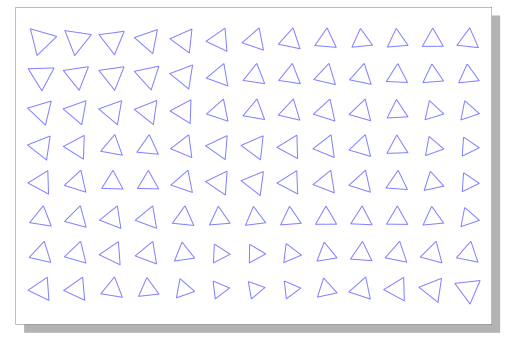

In [9]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

layer_shapes = []
for (x, y) in points:
    # sometimes you need to scale down the input values to the noise function
    # otherwise you lose the gradualness of the noise
    # here we're scaling down the input values to map from x/y coordinates
    # to the % of the width/height that point is located at
    # feel free to modify this even more (scale it up or down)
    xn = x / (W - MARGIN)
    yn = y / (H - MARGIN)

    # we'll use triangles as our shape function
    sfunc = triangle
    shape = sfunc((x, y), RADIUS)

    # here's our noise function
    noise = vsk.noise(xn, yn)

    rotatenoise = np.interp(
        noise, [0, 1], [0, 359]
    )  # map the noise value to a degree rotation
    scalenoise = np.interp(
        noise, [0, 1], [0.2, 1.2]
    )  # map the noise value to a scaling factor

    # here we will scale and rotate our shape by the noise value
    shape = affinity.scale(shape, scalenoise, scalenoise, origin="centroid")
    shape = affinity.rotate(shape, rotatenoise, origin="centroid")
    layer_shapes.append(shape)

vsk.geometry(geo.MultiPolygon(layer_shapes))
display(vsk)


## Pulling it all together

We now have all the components to make this piece. Here they are and how they connect:

- **Canvas**: the thing our sketch is drawn on (6x4 inches)
- **A border/margin**: to prevent ourselves from drawing outside the canvas or near the edges
- **Shapes**: we'll be drawing circles, triangles, and squares
- **A grid**: we'll be plotting our shapes on a rectangular grid, with the dimensions determined by a declared radius of our shapes
- **Layers**: we will create 3 layers so that the plotter will stop between layers and we can load in a new pen
- **Shape fill**: we created a vertical and two diagonal background fills for our shapes, which will be applied by determining the intersection of the fill and the shape
- **Voronoi diagram**: for a desired number of centroids, assign each point on the grid to the closest centroid. At each boundary, we will change the shape for some variety.
- **Perlin Noise**: within each Voronoi neighborhood, we will gradually rotate and scale the shape using Perlin noise


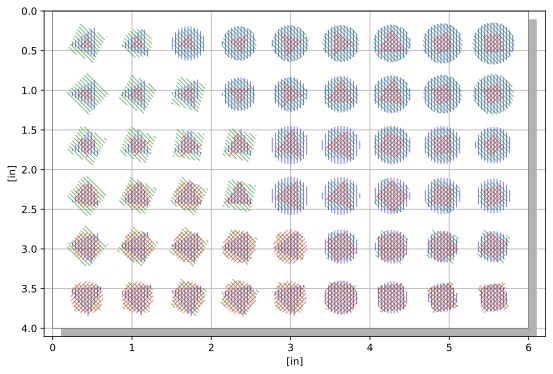

In [10]:
vsk = vsketch.Vsketch()
vsk.size("6x4in", center=True)

W = vsk.width
H = vsk.height

def circle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 16)


def diamond(center: Tuple[float, float], radius: float) -> geo.Polygon:
    return geo.Point(*center).buffer(radius, 1)


# https://stackoverflow.com/q/65544295
def triangle(center: Tuple[float, float], radius: float) -> geo.Polygon:
    side_length = radius * math.sqrt(3)
    # Calculate three vertices of the container triangle
    a = [center[0], center[1] + (math.sqrt(3) / 3) * side_length]  # Top vertex
    b = [
        center[0] - (side_length / 2),
        center[1] - (math.sqrt(3) / 6) * side_length,
    ]  # Bottom left vertex
    c = [center[0] + (side_length / 2), center[1] - (math.sqrt(3) / 6) * side_length]
    return geo.Polygon([a, b, c])

def nothing(center, radius):
    return geo.Polygon()

shapefuncs = [diamond, circle, triangle, nothing]


MARGIN = 25
BORDER = geo.LinearRing(
    [
        (MARGIN, MARGIN),
        (MARGIN, H - MARGIN),
        (W - MARGIN, H - MARGIN),
        (W - MARGIN, MARGIN),
    ]
)
BORDER_POLYGON = geo.Polygon(BORDER)

RADIUS = 30
SPACING = RADIUS * (2 + 0.05)

max_dim = max(vsk.width, vsk.height)

# Backgrounds
vsk.penWidth("0.5mm")
step = vsk.strokePenWidth * 2

vertical_lines = []
diag_right_lines = []
diag_left_lines = []
# Draw vertical lines from the left to the right of the canvacs
for x in np.arange(0, max_dim, step=step):
    vertical_lines.append(geo.LineString([(x, 0), (x, max_dim)]))

diag_right_base = geo.LineString([(0, 0), (max_dim, max_dim)])
diag_right_lines = [diag_right_base]
diag_left_base = geo.LineString([(0, max_dim), (max_dim, 0)])
diag_left_lines = [diag_left_base]

for r in np.arange(0, max_dim, step=step):
    diag_right_lines.append(
        affinity.translate(diag_right_base, r * math.sqrt(step / 2), 0)
    )
    diag_right_lines.append(
        affinity.translate(diag_right_base, 0, r * math.sqrt(step / 2))
    )
    diag_left_lines.append(
        affinity.translate(diag_left_base, -r * math.sqrt(step / 2), 0)
    )
    diag_left_lines.append(
        affinity.translate(diag_left_base, 0, r * math.sqrt(step / 2))
    ) 

layer_lines = [vertical_lines, diag_right_lines, diag_left_lines]
# Creates grid of points from Start Margin to End Margin
# with each point `SPACING` apart
xrange = np.arange(MARGIN, int(W - MARGIN), SPACING)
yrange = np.arange(MARGIN, int(H - MARGIN), SPACING)
xyrange = (xrange, yrange)
points = []
for x in xrange:
    for y in yrange:
        points.append((x, y))


def knn_grid(
    grid_points: List[Tuple[float, float]], k: int = 3, metric: str = "euclidean"
) -> List[int]:
    """
    Among a grid, randomly select 3 centroids and return a list of len(grid_points)
    with the ID of the closest centroid
    """
    centers = choices(grid_points, k=k)  # choose k points to be "centers"
    neigh = NearestNeighbors(n_neighbors=1, metric=metric)
    neigh.fit(centers)  # fit knn on those centers as the 'label'
    # for each point, return the 1st nearest neighbor
    closest_point = neigh.kneighbors(points, 1, return_distance=False)
    labels = list(c[0] for c in closest_point)
    return labels


def generate_layer_shapes(
    grid_points: List[Tuple[float, float]], labels: List[int]
) -> List[geo.Polygon]:
    n_unique_labels = len(set(labels))
    # Assign each neighborhood a shape
    label_shape_functions = {
        l: np.random.choice(shapefuncs) for l in range(n_unique_labels)
    }
    # add some arbitrary value for the noise 3rd dimension
    label_noise_start = {l: randint(0, 100) for l in range(n_unique_labels)}
    layer_shapes = []
    for (x, y), l in zip(grid_points, labels):
        vsk.stroke(l + 1)
        xn = x / (W - MARGIN)
        yn = y / (H - MARGIN)
        sfunc = label_shape_functions[l]
        shape = sfunc((x, y), RADIUS)
        noise = vsk.noise(xn, yn, label_noise_start[l])
        rotatenoise = np.interp(noise, [0, 1], [0, 359])
        scalenoise = np.interp(noise, [0, 1], [0.2, 1.1])
        shape = affinity.scale(shape, scalenoise, scalenoise, origin="centroid")
        shape = affinity.rotate(shape, rotatenoise, origin="centroid")
        layer_shapes.append(shape)
    return layer_shapes


l1_shapes = generate_layer_shapes(points, knn_grid(points, k=2))
l2_shapes = generate_layer_shapes(points, knn_grid(points, metric="cosine"))
l3_shapes = generate_layer_shapes(points, knn_grid(points))

vertical_lines_geo = geo.MultiLineString(vertical_lines)
diag_right_lines_geo = geo.MultiLineString(diag_right_lines)
diag_left_lines_geo = geo.MultiLineString(diag_left_lines)

def fill_layer_shapes(shapes: List[geo.Polygon], fill_lines: geo.MultiPolygon) -> List[geo.MultiLineString]:
    filled_shapes = []
    for shape in shapes:
        shape_filled = shape.intersection(fill_lines)
        filled_shapes.append(shape_filled)
    return filled_shapes

vsk.stroke(1)
for shape in fill_layer_shapes(l1_shapes, vertical_lines_geo):
    vsk.geometry(shape)
vsk.stroke(2)
for shape in fill_layer_shapes(l2_shapes, diag_right_lines_geo):
    vsk.geometry(shape)
vsk.stroke(3)
for shape in fill_layer_shapes(l3_shapes, diag_left_lines_geo):
    vsk.geometry(shape)

vsk.display(mode="matplotlib", fig_size=(6 * 1.5, 4 * 1.5), unit="in", grid=True)


In [11]:
vsk.vpype("linesimplify linemerge reloop linesort")
timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H-%M-%S")
vsk.save(f"knn-shapes-{timestamp}.svg")